<a href="https://colab.research.google.com/github/GreihMurray/5030/blob/master/lstm_chars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras import activations
import numpy as np
import itertools
from scipy.io import wavfile
from keras import backend as K
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Reshape, GRU, Flatten, Activation

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
import pandas as pd
from tqdm import tqdm
import os
import unicodedata
import re

from keras.models import load_model

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DEFAULT_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/NLP/project/'
SR = 44100

In [ ]:
def load_html_data(dir_ext):
    all_data = []
    chars_to_replace = '.,;:<>?/\'\\[]()!#$%"”“'
    directory = DEFAULT_DIR + 'html/' + dir_ext + '/'

    dir_files = sorted(os.listdir(directory))

    for file in tqdm(dir_files, desc='Loading HTML Data'):
        file = directory + file
        divs = []
        with open(file, 'r', encoding='UTF-8') as in_file:
            data = ' '.join(in_file.readlines())
            data = unicodedata.normalize('NFC', data)
            data = re.sub(r'<span class=.*?</span>', '', data)
            data = re.sub(r'<a.*?</a>', '', data)
            data = data.replace(u'\xa0', u' ')
            check_divs = re.findall(r'<div class=\'mt\'.*?>(.*?) </div>', data)
            check_divs.extend(re.findall(r'<div class=\'mt2\'.*?>(.*?) </div>', data))
            # print(data)
            check_divs.extend(re.findall(r'<div class=\'ip\'>(.*)', data))

            if len(check_divs) > 0:
                full = '!'.join(check_divs)
                full = re.sub(r'[\,,@,#,$,%,^,&,*,(,),\[,\],\',\",;,:,“,”,‘,’]', '', full)
                full = re.sub('^\s+', ' ', full).strip('\u00A0')
                full = re.split('[\.,\?,!,\n]', str(full))
                all_data.extend([s.strip() for s in full])

            divs.extend(re.findall(r'<div class=\'[p,s]\'.*?>(.*?) </div>', data))

        full_data = '!'.join(divs)
        full_data = re.sub(r'[\,,@,#,$,%,^,&,*,(,),\[,\],\',\",;,:,“,”,‘,’]', '', full_data)
        full_data = re.sub(' +', ' ', full_data)
        full_data = re.split('[\.,\?,!,\n]', str(full_data))

        all_data.extend([s.strip() for s in full_data])

        clean = []
        for row2 in all_data:
            if len(row2) >= 1:
                clean.append(row2.lower())

    return clean

In [ ]:
def load_dataset(dir_ext):
    transcripts = load_html_data(dir_ext)
    all_x = []
    all_y = []
    directory = DEFAULT_DIR + 'audio/' + dir_ext + '/'

    order = []

    dir_files = sorted(os.listdir(directory))

    for i, file in tqdm(enumerate(dir_files), desc='Loading Audio Data & Creating Dataset'):
        file = directory + file
        
        sr, data = wavfile.read(file)

        max_len = SR//1000 * 15000

        if len(data) > max_len:
          continue

        all_x.append(data)
        all_y.append(transcripts[i])


    return pd.DataFrame(list(zip(all_x, all_y)), columns=['audio', 'transcription'])

In [ ]:
def one_hot(data):
    mapping = {}
    mapped = []

    i = 0

    for sentence in data:
      cur_map = []
      for word in sentence:
          if word in mapping.keys():
            cur_map.append(mapping[word])
          else:
            i += 1
            cur_map.append(i)
            mapping[word] = i
            
      mapped.append(cur_map)
      
    return mapped, mapping

In [ ]:
def vectorize(data):
    vecs = []
    for row in data:
      cur_vec = [0] * len(row[0])
      for piece in row:
        piece = list(piece)
        cur_vec[piece.index(1)] += 1
      cur_vec[2] = 1
      vecs.append(cur_vec)

    return vecs

In [ ]:
def pad_audio(data):
    max_len = SR//1000 * 15000

    for i, aud in tqdm(enumerate(data), desc='Padding audio'):
      if len(aud) < max_len:
        data[i] = np.array(np.append(aud, np.zeros(max_len - len(aud))))

    return data

In [ ]:
def get_min(audio):
    minim = 0

    for row in tqdm(audio, desc='Finding min'):
        if min(row) < minim:
            minim = min(row)
    
    return minim

In [ ]:
def get_max(audio):
    maxim = 0

    for row in tqdm(audio, desc='Finding max'):
        if max(row) > maxim:
           maxim = max(row)

    return maxim

In [ ]:
def adjust_audio(audio, minim):
    for i, row in tqdm(enumerate(audio), desc='Adjusting Audio'):
        for j, val in enumerate(row):
            audio[i][j] = int(val + abs(minim))

    return audio

In [ ]:
def advanced_relu(x):
    return K.relu(x, max_value=500000)

In [ ]:
def build_model(input_len, output_len, maxim):
    model = Sequential()
    model.add(Dense(321, input_shape=(input_len,), activation=advanced_relu))
    model.add(Embedding(input_dim=499999, output_dim=34))
    model.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)))
    model.add(Dense(34, activation='softmax'))
    #model.add(Reshape((321, 34)))
    
    model.compile(optimizer="adam", metrics=["accuracy"], loss='categorical_crossentropy')


    return model

In [ ]:
df = load_dataset('train')

Loading HTML Data: 100%|██████████| 293/293 [00:02<00:00, 135.62it/s]
Loading Audio Data & Creating Dataset: 0it [00:00, ?it/s]<ipython-input-6-6963f008061e>:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = wavfile.read(file)
Loading Audio Data & Creating Dataset: 356it [00:04, 85.41it/s] 


In [ ]:
clean_y = list(df['transcription'])

In [ ]:
padded_y = list(zip(*itertools.zip_longest(*list(df['transcription']), fillvalue='!')))
enc_y, mapping = one_hot(padded_y)
cat_y = np.array(to_categorical(enc_y))
#vec_y = np.array(vectorize(cat_y))

In [ ]:
print(cat_y.shape)

(306, 321, 34)


In [ ]:
padded_x = pad_audio(df['audio'])

Padding audio: 306it [00:01, 175.42it/s]


In [ ]:
del df

In [ ]:
print(padded_x[0])

[-41. -35. -10. ...   0.   0.   0.]


In [ ]:
minim = get_min(padded_x)

Finding min: 100%|██████████| 306/306 [00:14<00:00, 21.57it/s]


In [ ]:
print(minim)

-29101.0


In [ ]:
padded_x = adjust_audio(padded_x, minim)

Adjusting Audio: 306it [10:25,  2.04s/it]


In [ ]:
maxim = get_max(padded_x)

Finding max: 100%|██████████| 306/306 [00:13<00:00, 22.03it/s]


In [ ]:
print(maxim)

59374.0


In [ ]:
padded_x = np.stack(padded_x)

In [ ]:
print(len(padded_x[0]))

660000


In [ ]:
model = build_model(len(padded_x[0]), len(cat_y[0]), maxim)

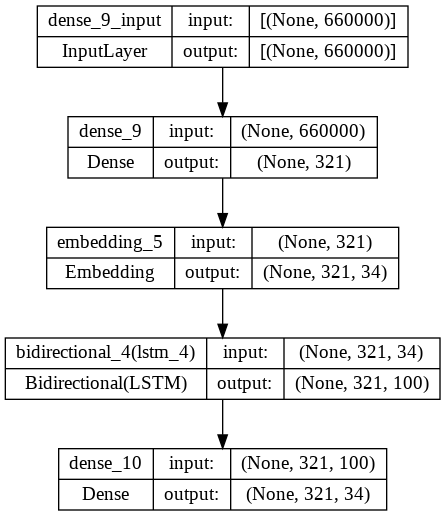

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
print(padded_x.shape)
print(padded_x[0].shape)
print(cat_y.shape)

(306, 660000)
(660000,)
(306, 321, 34)


In [ ]:
clean_cat = cat_y

In [ ]:
for entry in cat_y:
    for row in entry:
        if row[7] != 0:
            row[7] = 0

In [ ]:
print(cat_y[0])

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
model = load_model('/content/gdrive/MyDrive/Colab_Notebooks/NLP/project/lstm_model_450e')

In [ ]:
model.fit(padded_x, cat_y, epochs=100, verbose=1, batch_size=1)

Epoch 1/100
306/306 [==============================] - 130s 425ms/step - loss: 0.0524 - accuracy: 0.2625
Epoch 2/100
306/306 [==============================] - 128s 418ms/step - loss: 0.0512 - accuracy: 0.2630
Epoch 3/100
306/306 [==============================] - 128s 418ms/step - loss: 0.0522 - accuracy: 0.2626
Epoch 4/100
306/306 [==============================] - 131s 427ms/step - loss: 0.0519 - accuracy: 0.2629
Epoch 5/100
306/306 [==============================] - 130s 425ms/step - loss: 0.0521 - accuracy: 0.2628
Epoch 6/100
306/306 [==============================] - 130s 425ms/step - loss: 0.0535 - accuracy: 0.2619
Epoch 7/100
306/306 [==============================] - 131s 426ms/step - loss: 0.0525 - accuracy: 0.2625
Epoch 8/100
306/306 [==============================] - 127s 414ms/step - loss: 0.0520 - accuracy: 0.2626
Epoch 9/100
306/306 [==============================] - 127s 414ms/step - loss: 0.0519 - accuracy: 0.2623
Epoch 10/100
306/306 [==============================] -

In [ ]:
model.save('/content/gdrive/MyDrive/Colab_Notebooks/NLP/project/lstm_model_700e')

In [ ]:
preds = model.predict(padded_x[:5])

1/1 [==============================] - 1s 989ms/step


In [ ]:
print(list(preds[0]))

[array([7.4489940e-06, 9.6941310e-01, 3.2109942e-04, 7.2230464e-03,
       1.1380565e-05, 1.5110786e-03, 1.6775189e-03, 3.6445581e-06,
       8.2396960e-04, 1.0566498e-05, 1.7440834e-04, 7.5822223e-05,
       2.6772515e-05, 2.2180150e-03, 2.1034521e-05, 1.0619802e-04,
       2.9523345e-04, 4.5644245e-03, 1.8787320e-03, 8.1437011e-04,
       2.0996611e-04, 2.3086241e-03, 2.9783972e-04, 5.4029180e-05,
       1.3037091e-04, 5.0311577e-05, 3.2235618e-04, 1.5376457e-04,
       9.4653270e-04, 2.4076325e-03, 1.1066088e-03, 1.9211209e-04,
       4.8108681e-04, 1.6098660e-04], dtype=float32), array([9.8989140e-06, 3.4119841e-04, 9.6957439e-01, 5.1377891e-03,
       2.6676559e-04, 6.4665569e-06, 5.5879205e-03, 7.6642418e-06,
       1.0008811e-03, 4.3541786e-06, 7.2372914e-04, 4.1798259e-05,
       1.0929938e-02, 1.3625053e-04, 1.5439207e-04, 7.7493297e-04,
       1.2990366e-03, 3.1371336e-04, 3.6886835e-05, 3.2936237e-05,
       2.4384349e-04, 7.5920270e-04, 1.9824336e-04, 1.7291092e-04,
       

In [ ]:
model.evaluate(padded_x, cat_y, verbose=1)

10/10 [==============================] - 4s 325ms/step - loss: 0.3508 - accuracy: 0.1782


[0.3507947623729706, 0.17820128798484802]

In [ ]:
print(mapping)

In [ ]:
print(list(preds[0][0]))

[7.448994e-06, 0.9694131, 0.00032109942, 0.0072230464, 1.1380565e-05, 0.0015110786, 0.001677519, 3.644558e-06, 0.0008239696, 1.0566498e-05, 0.00017440834, 7.582222e-05, 2.6772515e-05, 0.002218015, 2.103452e-05, 0.00010619802, 0.00029523345, 0.0045644245, 0.001878732, 0.0008143701, 0.0002099661, 0.002308624, 0.00029783972, 5.402918e-05, 0.00013037091, 5.0311577e-05, 0.00032235618, 0.00015376457, 0.0009465327, 0.0024076325, 0.0011066088, 0.00019211209, 0.0004810868, 0.0001609866]


In [ ]:
cur_words = []

map_list = mapping.items()
map_key = list(mapping.keys())

last_char = False

all_words = []

preds = model.predict(padded_x)

print(len(preds))

for pred in preds:
    cur_words = []
    for row in pred:
        row = list(row)
        cur_words.append(map_key[row.index(max(row))-1])
        
    len_words = len(cur_words) - 1

    for i in range(len_words, 0, -1):
        if cur_words[i] != ' ':
            joined = ''.join(cur_words)
            all_words.append(re.sub(' +', ' ', joined))
            break
        else:
            cur_words.pop()



print(all_words)

10/10 [==============================] - 3s 320ms/step
306
['jenaaa', 'ola basdamwan st', 'wal dijan im stat garram det stori blanga god weta iiii ieei i i', 'god bin meigim en iui', 'orait lyngaaim wen gbd bin kand meigimba abai mmmm eiiii iii', 'imbin jis eniwei nomo garra deniji', ' ni t bnuuala woda bin goran goran ebriwei en imbbn ba bli dakbina ei det spirit blanga god bbb mubabat ontop langa det', 'irm ddeya god bin tok la', ' eeie n', 'en wen god bin luk det lait bin gudwan imbin gum aaa', 'brom deya god bin kadimat det lait brom det dakbala en imbin gulum det lait deitaim en iibin gad m det ddbat on', 'brom deya naitaim bin go eieiiiwen imbin ailibala imbin det sekan dei', 'brom deya god bin t b larram samting j nnn blaa t dd oda en n iiimiiii', 'en imbin hepin lagijat nn dumabi god bin guima det ting en iit ting bin kadimat det woda langa bodam brom det woda langa top lnnggg biinn e nn', 'brom deya god biintok larram det woda langa badam hipimap miselp langa nan lleing aaaaa 

In [ ]:
print(mapping)

{'j': 1, 'e': 2, 'n': 3, 'a': 4, 's': 5, 'i': 6, '!': 7, 'o': 8, 'l': 9, ' ': 10, 'b': 11, 'd': 12, 'm': 13, 'w': 14, 't': 15, 'r': 16, 'g': 17, 'y': 18, 'f': 19, 'u': 20, 'k': 21, 'p': 22, 'h': 23, '4': 24, '5': 25, '7': 26, '3': 27, '9': 28, '0': 29, '1': 30, '2': 31, '6': 32, '8': 33}


In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.0 MB/s 
     |████████████████████████████████| 451 kB 8.7 MB/s 
     |████████████████████████████████| 132 kB 50.4 MB/s 
     |████████████████████████████████| 212 kB 54.2 MB/s 
     |████████████████████████████████| 182 kB 43.0 MB/s 
     |████████████████████████████████| 127 kB 79.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 2.2 MB 43.4 MB/s 


In [ ]:
from evaluate import load

In [ ]:
cer = load('cer')
cer_score = cer.compute(predictions=all_words, references=clean_y[:305])
print(cer_score)

0.5414538455844252


In [ ]:
wer = load('wer')
wer_score = wer.compute(predictions=all_words, references=clean_y[:305])
print(wer_score)

0.7680219996071499
